In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import librosa.display


In [2]:
def convert_hz_to_bark(frequencies):
    return 6.0 * torch.arcsinh(torch.tensor(frequencies, dtype=torch.float32) / 600.0)

def convert_bark_to_hz(bark_values):
    return 600.0 * torch.sinh(torch.tensor(bark_values, dtype=torch.float32) / 6.0)

def compute_spreading_function_dB(max_freq, num_filters):
    max_bark = convert_hz_to_bark(max_freq)
    spreading_function_dB = torch.zeros(2 * num_filters)
    spreading_function_dB[:num_filters] = torch.linspace(-max_bark * 27, -8, num_filters) - 23.5
    spreading_function_dB[num_filters:] = torch.linspace(0, -max_bark * 12.0, num_filters) - 23.5
    return spreading_function_dB

def create_spreading_function_matrix(spreading_function_dB, alpha, num_filters):
    spreading_function_voltage = 10.0 ** (spreading_function_dB / 20.0 * alpha)
    spreading_function_matrix = torch.zeros((num_filters, num_filters))
    for k in range(num_filters):
        spreading_function_matrix[k, :] = spreading_function_voltage[(num_filters - k):(2 * num_filters - k)]
    return spreading_function_matrix

def create_bark_matrix(sample_rate, num_filters, fft_size):
    max_bark = convert_hz_to_bark(sample_rate / 2)
    step_bark = max_bark / (num_filters - 1)
    bin_bark = convert_hz_to_bark(torch.linspace(0, (fft_size / 2), (fft_size // 2) + 1) * sample_rate / fft_size)
    bark_matrix = torch.zeros((num_filters, fft_size))
    for i in range(num_filters):
        bark_matrix[i, :fft_size // 2 + 1] = (torch.round(bin_bark / step_bark) == i)
    return bark_matrix

def apply_bark_filtering(mX, bark_matrix, fft_size):
    return (torch.matmul(torch.abs(mX[:fft_size // 2]) ** 2.0, bark_matrix[:, :fft_size // 2].T)) ** 0.5

def invert_bark_matrix(bark_matrix, fft_size):
    inv_bark_matrix = torch.matmul(torch.diag((1.0 / (torch.sum(bark_matrix, 1) + 1e-6)) ** 0.5), bark_matrix[:, :fft_size // 2 + 1]).T
    return inv_bark_matrix

def calculate_masking_threshold(mX_bark, spreading_function_matrix, alpha, sample_rate, num_filters):
    mT_bark = torch.matmul(mX_bark ** alpha, spreading_function_matrix ** alpha)
    mT_bark = mT_bark ** (1.0 / alpha)
    max_bark = convert_hz_to_bark(sample_rate / 2.0)
    bark_steps = torch.arange(0, num_filters) * (max_bark / (num_filters - 1))
    frequencies = convert_bark_to_hz(bark_steps) + 1e-6
    quiet_threshold = torch.clip((3.64 * (frequencies / 1000.0) ** -0.8 -
                                   6.5 * torch.exp(-0.6 * (frequencies / 1000.0 - 3.3) ** 2.0) +
                                   1e-3 * (frequencies / 1000.0) ** 4.0), -20, 120)
    a = mT_bark
    b = 10.0 ** ((quiet_threshold - 60) / 20)
    return torch.max(a, b)

def compute_masking_threshold(ys, sample_rate):
    max_frequency = sample_rate / 2
    exponent = 0.8
    num_filters = 64
    num_blocks = ys.shape[1]
    num_bins = ys.shape[0] - 1
    fft_size = 2 * num_bins
    
    bark_matrix = create_bark_matrix(sample_rate, num_filters, fft_size)
    inv_bark_matrix = invert_bark_matrix(bark_matrix, fft_size)
    spreading_function_dB = compute_spreading_function_dB(max_frequency, num_filters)
    spreading_function_matrix = create_spreading_function_matrix(spreading_function_dB, exponent, num_filters)
    
    masking_threshold = torch.zeros((num_bins + 1, num_blocks))
    for block in range(num_blocks):
        magnitude_spectrum = torch.abs(ys[:, block])
        bark_spectrum = apply_bark_filtering(magnitude_spectrum, bark_matrix, fft_size)
        masking_threshold_bark = calculate_masking_threshold(
            bark_spectrum, spreading_function_matrix, exponent, sample_rate, num_filters)
        masking_threshold[:, block] = torch.matmul(masking_threshold_bark, inv_bark_matrix[:, :fft_size // 2].T.float())
    
    return masking_threshold


In [3]:
def calculate_perceptual_loss(original, modified, sample_rate):
    fft_size = 2048
    num_bins = fft_size // 2
    
    original_stft = torch.stft(original, n_fft=fft_size, hop_length=fft_size // 2,
                               return_complex=True, normalized=True, window=torch.hann_window(fft_size))
    modified_stft = torch.stft(modified, n_fft=fft_size, hop_length=fft_size // 2,
                               return_complex=True, normalized=True, window=torch.hann_window(fft_size))
    
    masking_threshold = compute_masking_threshold(original_stft, sample_rate)
    
    normalized_diff_spectrum = torch.abs((original_stft - modified_stft) / masking_threshold)
    perceptual_loss = torch.mean(normalized_diff_spectrum ** 2)
    
    return perceptual_loss


In [4]:
def apply_aac_simulation(signal, preservation_ratio=0.9):
    noise = np.random.normal(0, 0.01, len(signal))
    simulated_signal = signal * preservation_ratio + noise
    return simulated_signal

def perform_quantization(signal, num_levels):
    return np.round(signal * (num_levels - 1)) / (num_levels - 1)

def visualize_audio_comparison(original, quantized, aac_encoded, sample_rate):
    plt.figure(figsize=(15, 5))
    
    original_normalized = original / np.max(np.abs(original))
    quantized_normalized = quantized / np.max(np.abs(quantized))
    aac_normalized = aac_encoded / np.max(np.abs(aac_encoded))
    
    plt.subplot(1, 3, 1)
    librosa.display.waveshow(original_normalized, sr=sample_rate, color='blue')
    plt.title('Original Audio')
    
    plt.subplot(1, 3, 2)
    librosa.display.waveshow(quantized_normalized, sr=sample_rate, color='green')
    plt.title('Quantized Audio')
    
    plt.subplot(1, 3, 3)
    librosa.display.waveshow(aac_normalized, sr=sample_rate, color='red')
    plt.title('AAC Encoded Audio')
    
    plt.tight_layout()
    plt.show()


In [5]:
def process_audio_files(audio_files_path):
    dir_list = os.listdir(audio_files_path)
    data = []

    for file_name in dir_list:
        if file_name.endswith('.wav'):
            genre = file_name.split('_')[0]
            file_path = os.path.join(audio_files_path, file_name)
            
            try:
                print(f"Processing file: {file_name}, Genre: {genre}")
                
                sample_rate, audio_data = wavfile.read(file_path)
                
                if audio_data.ndim > 1:
                    audio_data = np.mean(audio_data, axis=1)
                
                audio_data = audio_data.astype(float) / np.max(np.abs(audio_data))
                
                quantized_audio = perform_quantization(audio_data, 4)
                simulated_aac_audio = apply_aac_simulation(audio_data)
                
                loss_quant = calculate_perceptual_loss(torch.from_numpy(audio_data).float(), 
                                                       torch.from_numpy(quantized_audio).float(), 
                                                       sample_rate)
                loss_aac = calculate_perceptual_loss(torch.from_numpy(audio_data).float(), 
                                                     torch.from_numpy(simulated_aac_audio).float(), 
                                                     sample_rate)
                loss_ratio = loss_aac / loss_quant
                
                print(f"Perceptual Loss (Quantized): {loss_quant.item()}, Perceptual Loss (AAC): {loss_aac.item()}, Ratio: {loss_ratio.item()}")
                
                visualize_audio_comparison(audio_data, quantized_audio, simulated_aac_audio, sample_rate)
                
                data.append({
                    'file_name': file_name,
                    'genre': genre,
                    'ploss_quant': loss_quant.item(),
                    'ploss_aac': loss_aac.item(),
                    'aac_to_quant_loss_ratio': loss_ratio.item()
                })
                
            except Exception as error:
                print(f"Error processing file: {file_path}")
                print(f"Error details: {str(error)}")
    
    return pd.DataFrame(data)


Processing file: drum_office_3.wav, Genre: drum


C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\1738680395.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)
C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\4116884458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 6.0 * torch.arcsinh(torch.tensor(frequencies, dtype=torch.float32) / 600.0)
C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\4116884458.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 600.0 * torch.sinh(torch.tensor(bark_values, dtype=torch.float32) / 6.0)


Perceptual Loss (Quantized): 455.3360900878906, Perceptual Loss (AAC): 62.954925537109375, Ratio: 0.1382603496313095


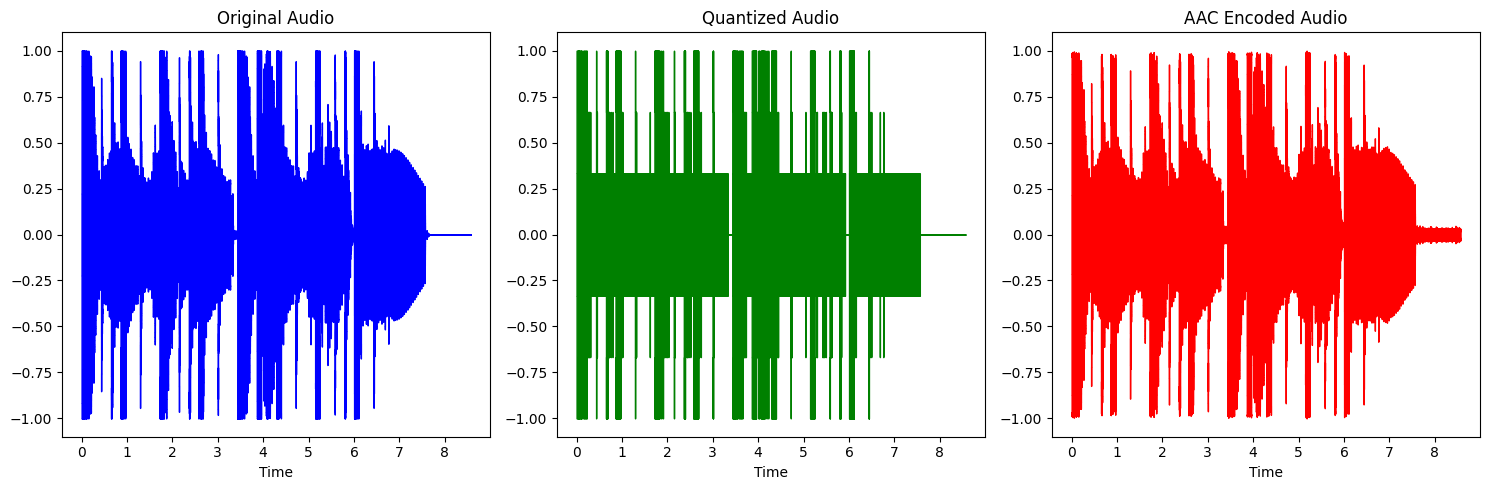

Processing file: drum_reverbance_3.wav, Genre: drum


C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\1738680395.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)
C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\4116884458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 6.0 * torch.arcsinh(torch.tensor(frequencies, dtype=torch.float32) / 600.0)
C:\Users\annsb\AppData\Local\Temp\ipykernel_15524\4116884458.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 600.0 * torch.sinh(torch.tensor(bark_values, dtype=torch.float32) / 6.0)


Perceptual Loss (Quantized): 113.76714324951172, Perceptual Loss (AAC): 33.16511154174805, Ratio: 0.2915174961090088


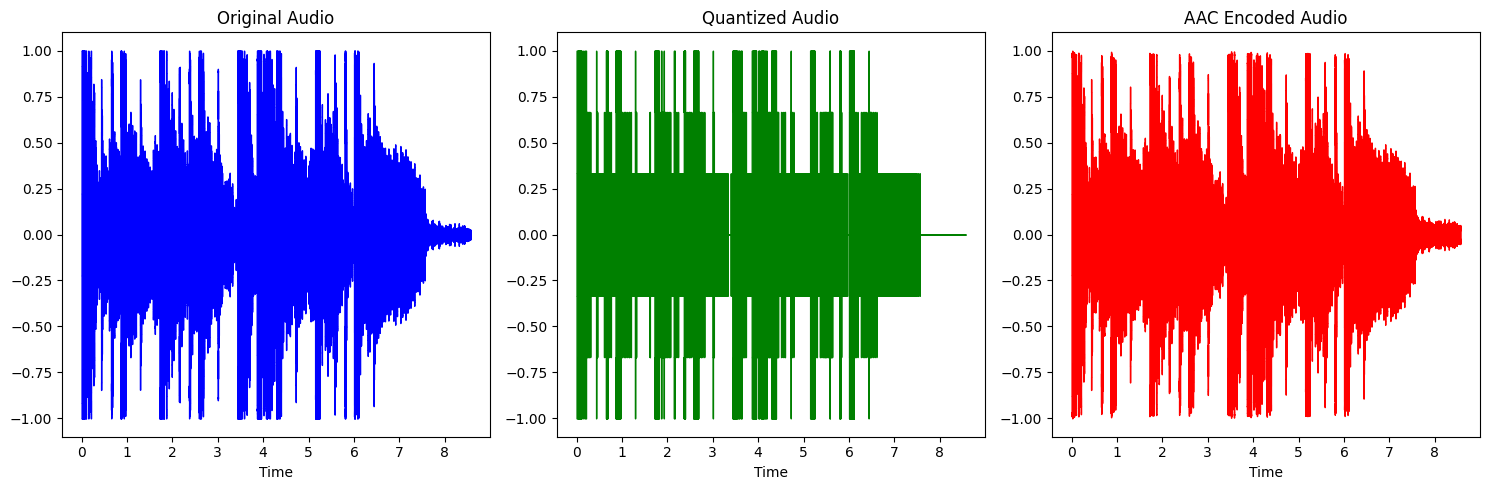

Processing file: drum_reverbhall_3.wav, Genre: drum
Perceptual Loss (Quantized): 128.37155151367188, Perceptual Loss (AAC): 43.01713562011719, Ratio: 0.33509865403175354


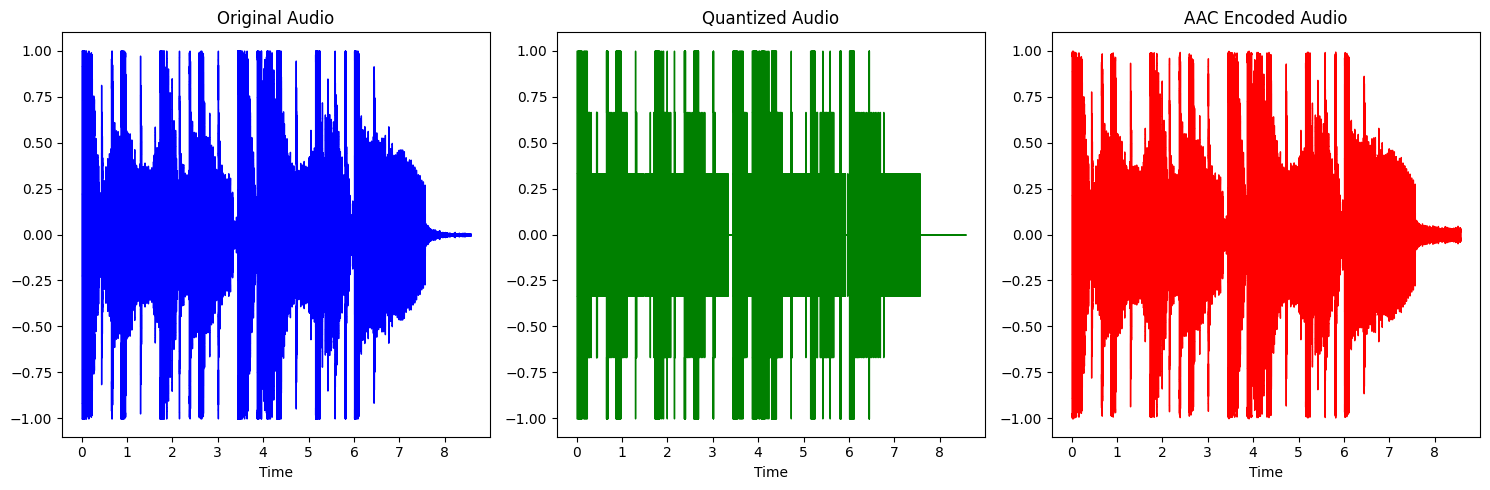

Processing file: drum_sound-3.wav, Genre: drum
Perceptual Loss (Quantized): 445.5110168457031, Perceptual Loss (AAC): 64.5815200805664, Ratio: 0.14496055245399475


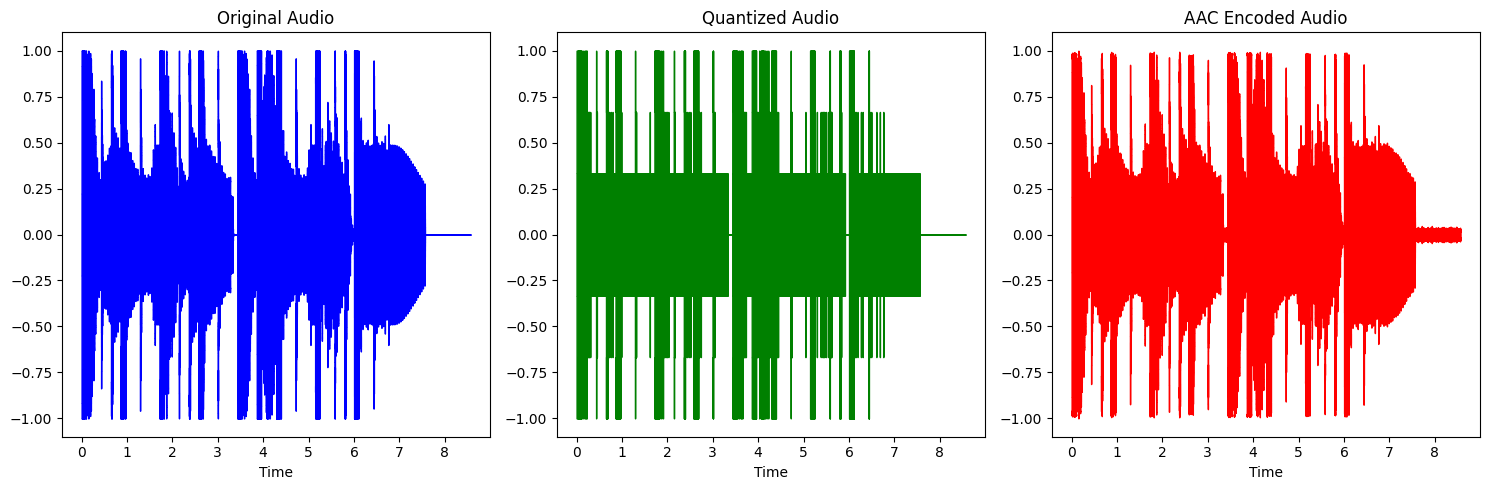

Processing file: music_mix_office_1.wav, Genre: music
Perceptual Loss (Quantized): 8.846881866455078, Perceptual Loss (AAC): 0.9936056733131409, Ratio: 0.11231140047311783


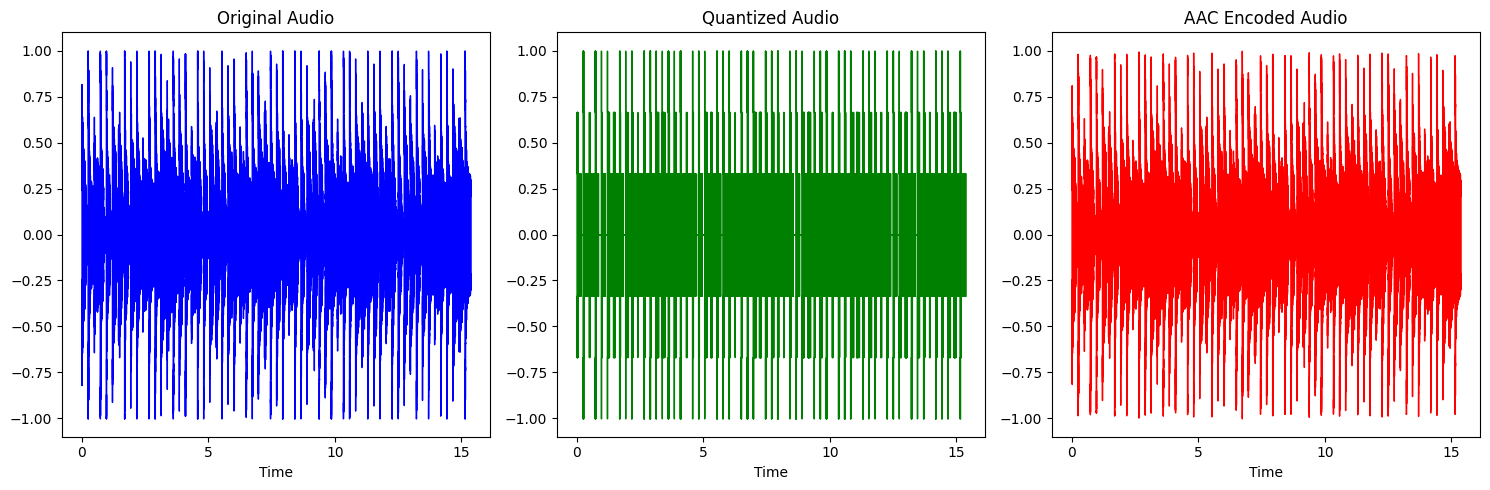

Processing file: music_mix_reverbance_1.wav, Genre: music
Perceptual Loss (Quantized): 12.71433162689209, Perceptual Loss (AAC): 0.5174559950828552, Ratio: 0.040698640048503876


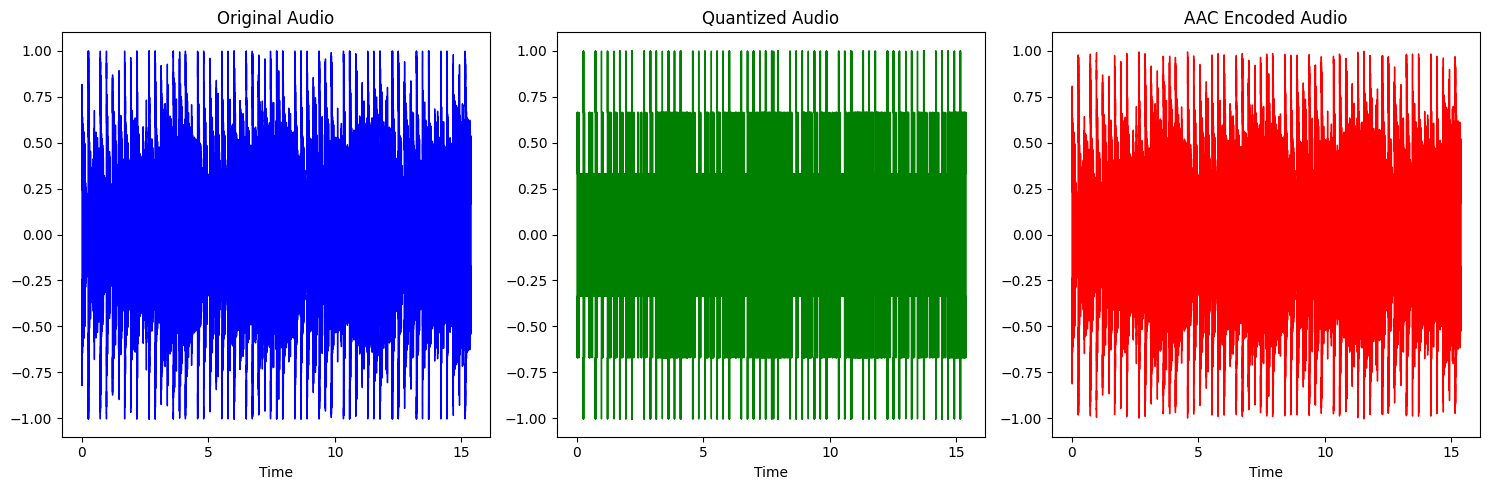

Processing file: music_mix_reverbhall_1.wav, Genre: music
Perceptual Loss (Quantized): 9.347469329833984, Perceptual Loss (AAC): 0.986598551273346, Ratio: 0.10554713010787964


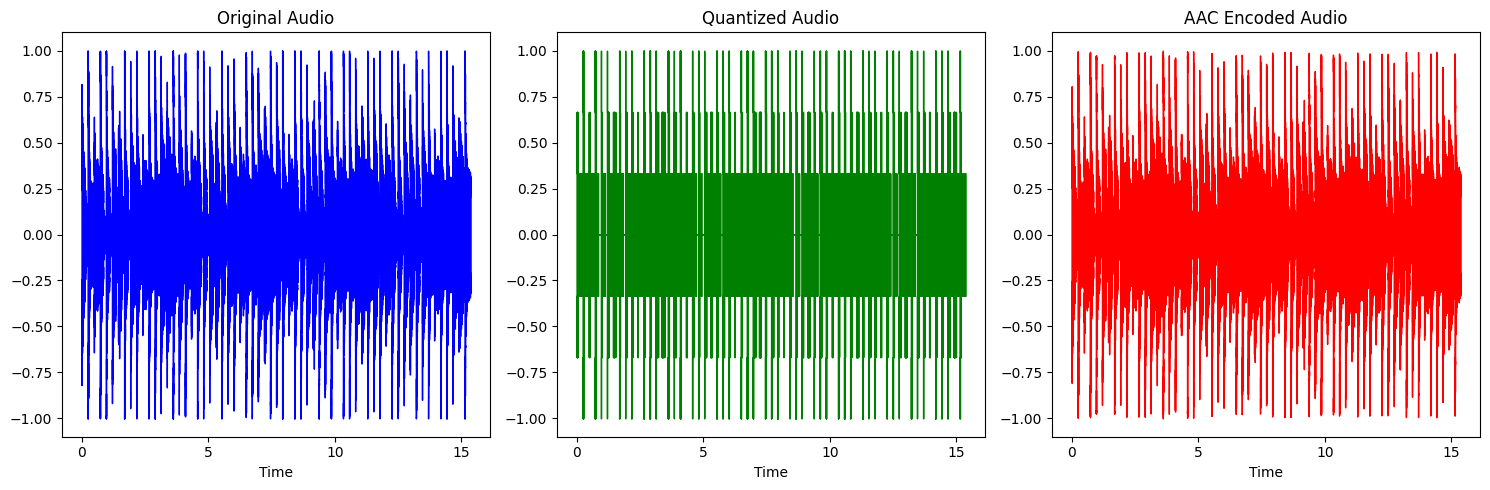

Processing file: music_mix_sound-1.wav, Genre: music
Perceptual Loss (Quantized): 4.89434814453125, Perceptual Loss (AAC): 2.823742151260376, Ratio: 0.5769393444061279


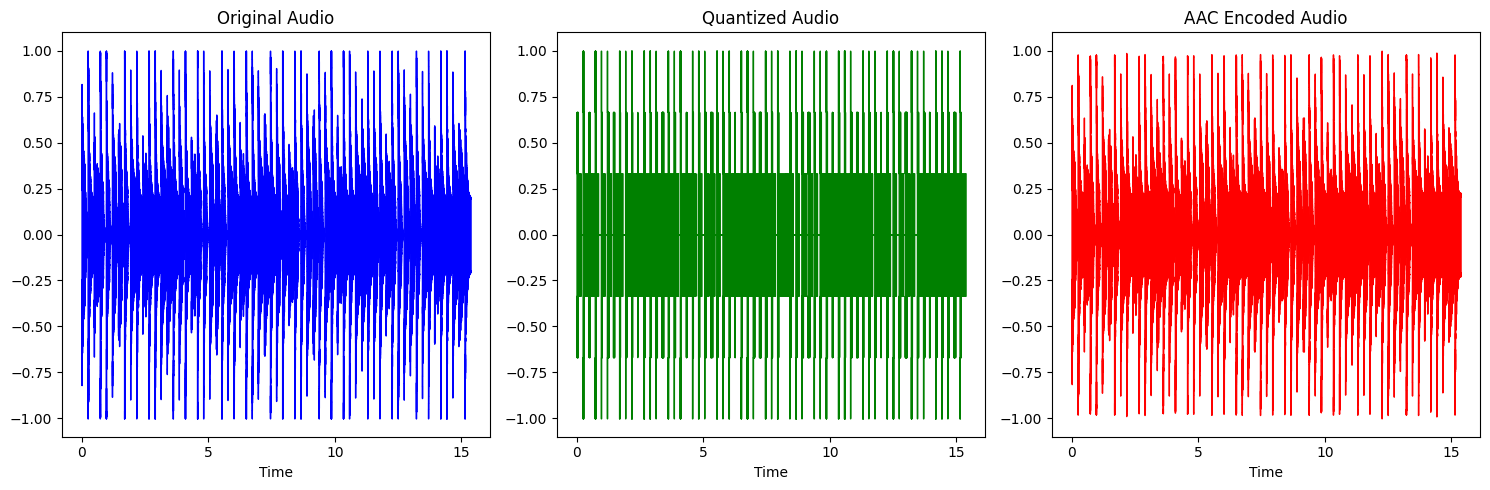

Processing file: piano_office_5.wav, Genre: piano
Perceptual Loss (Quantized): 278.9172058105469, Perceptual Loss (AAC): 72.06779479980469, Ratio: 0.25838419795036316


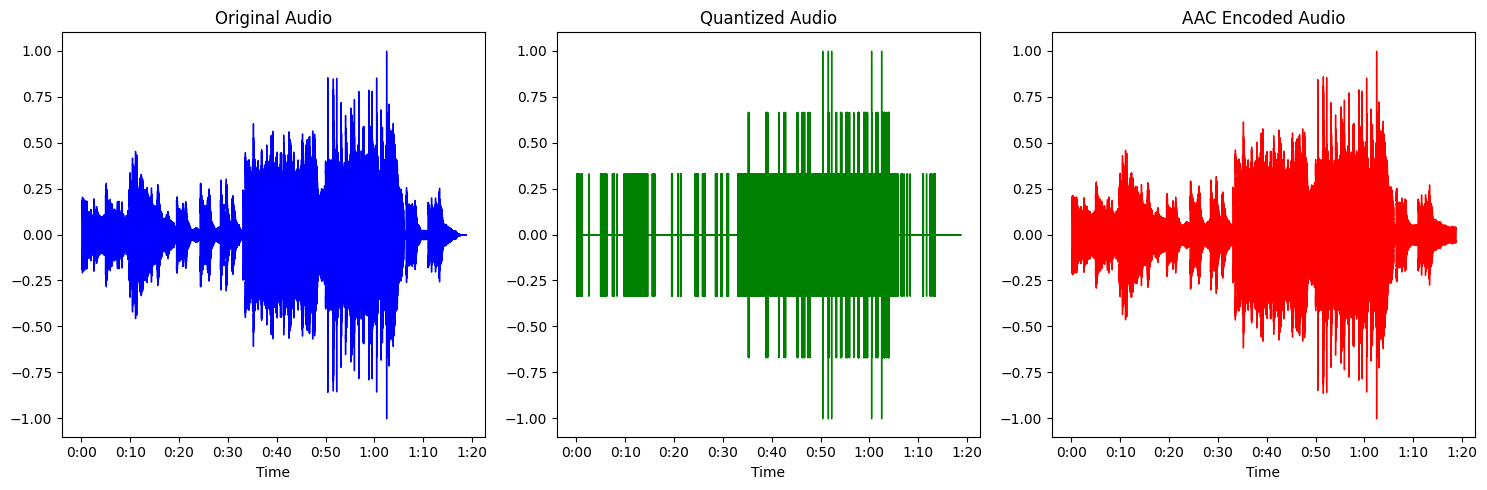

Processing file: piano_reverbance_5.wav, Genre: piano
Perceptual Loss (Quantized): 436.6371765136719, Perceptual Loss (AAC): 68.8414535522461, Ratio: 0.15766283869743347


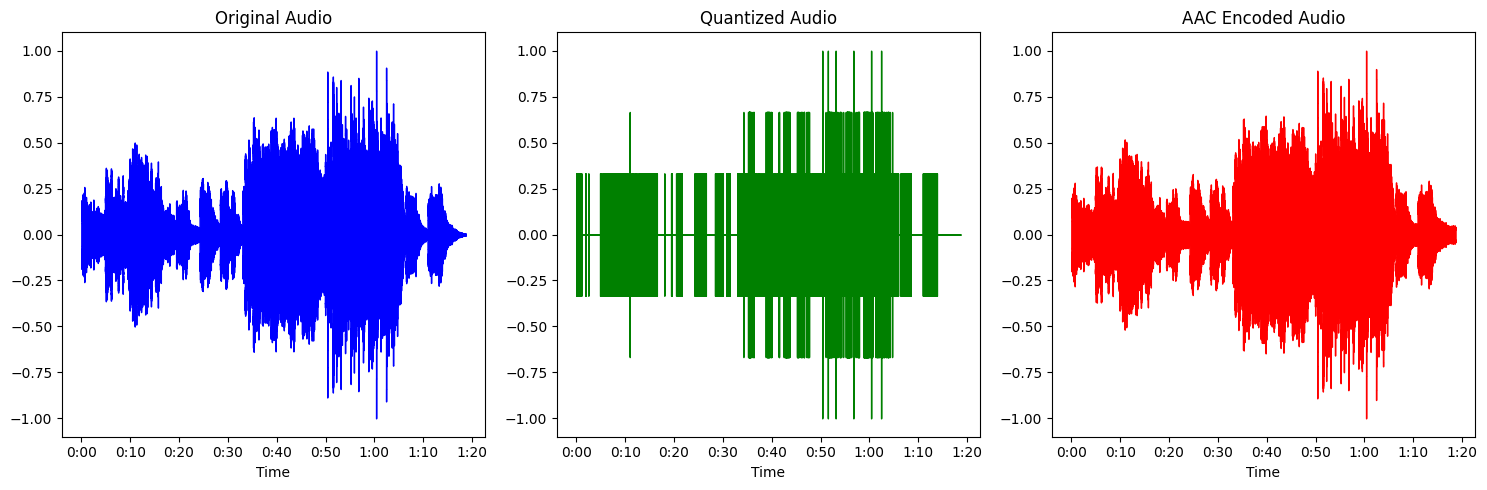

Processing file: piano_reverbhall_5.wav, Genre: piano
Perceptual Loss (Quantized): 304.328125, Perceptual Loss (AAC): 71.29720306396484, Ratio: 0.2342773973941803


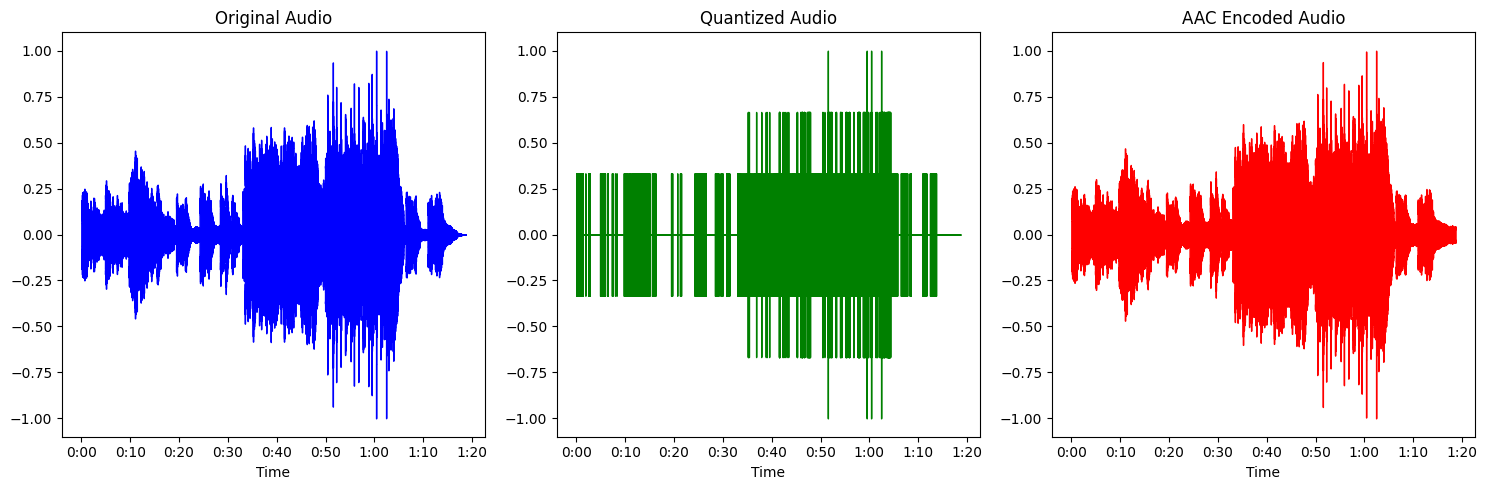

Processing file: piano_sound-5.wav, Genre: piano
Perceptual Loss (Quantized): 261.9612731933594, Perceptual Loss (AAC): 70.45777893066406, Ratio: 0.268962562084198


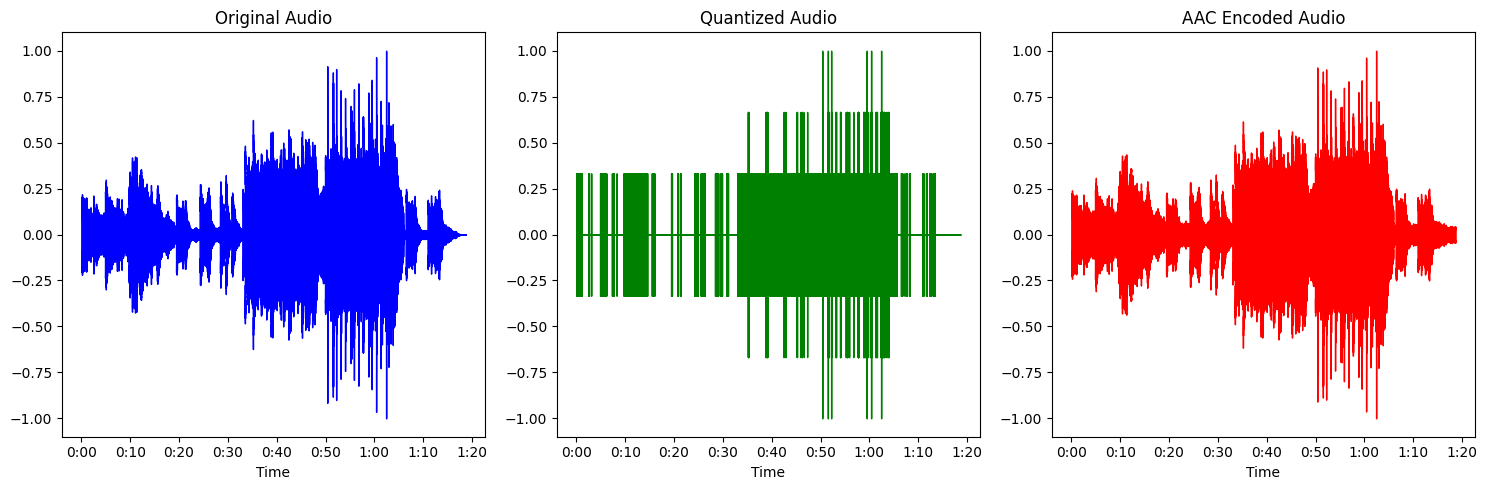

Processing file: ringtone_office_2.wav, Genre: ringtone
Perceptual Loss (Quantized): 48.30392837524414, Perceptual Loss (AAC): 19.026060104370117, Ratio: 0.39388224482536316


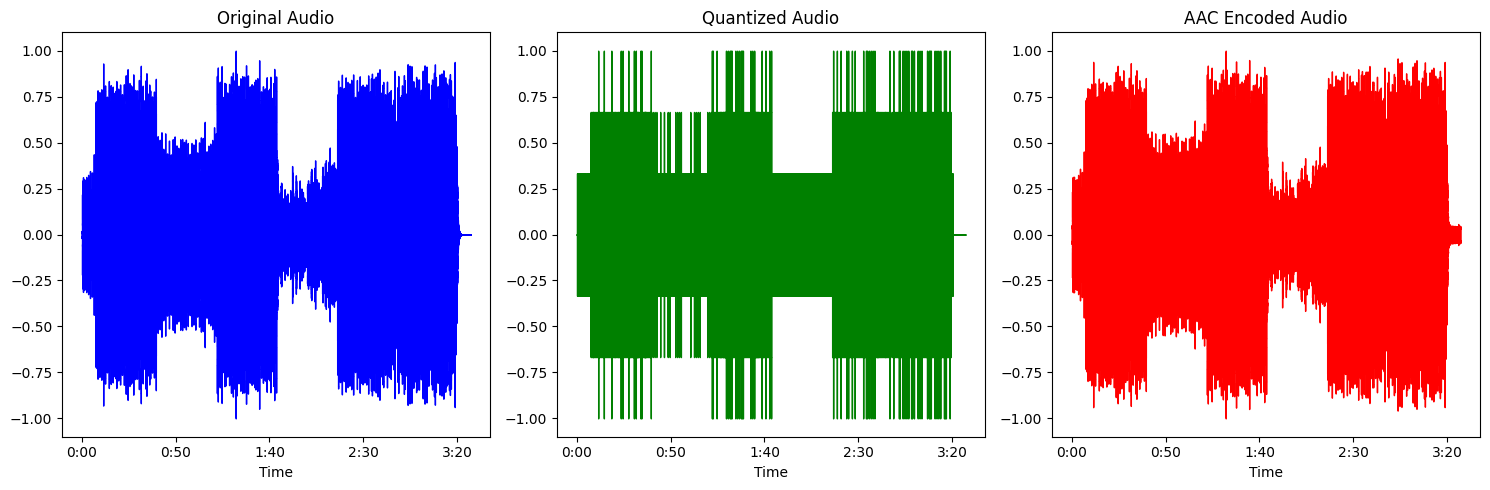

Processing file: ringtone_reverbance_2.wav, Genre: ringtone
Perceptual Loss (Quantized): 108.40294647216797, Perceptual Loss (AAC): 17.989957809448242, Ratio: 0.16595451533794403


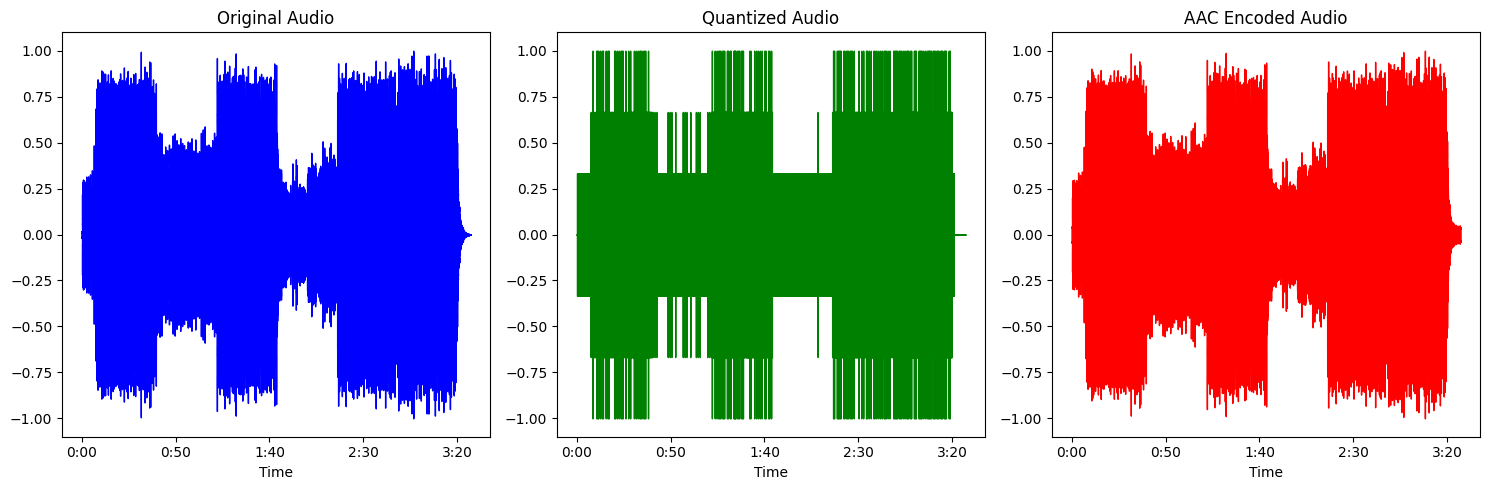

Processing file: ringtone_reverbhall_2.wav, Genre: ringtone
Perceptual Loss (Quantized): 50.110870361328125, Perceptual Loss (AAC): 18.7834415435791, Ratio: 0.3748376667499542


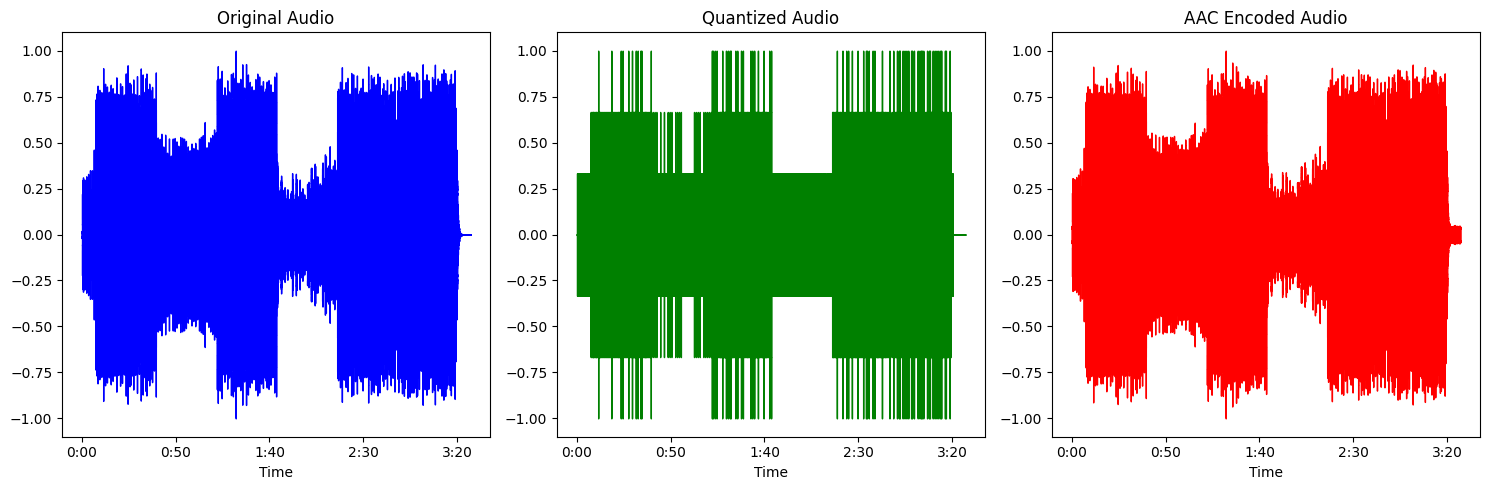

Processing file: ringtone_sound-2.wav, Genre: ringtone
Perceptual Loss (Quantized): 45.502601623535156, Perceptual Loss (AAC): 18.94063377380371, Ratio: 0.41625386476516724


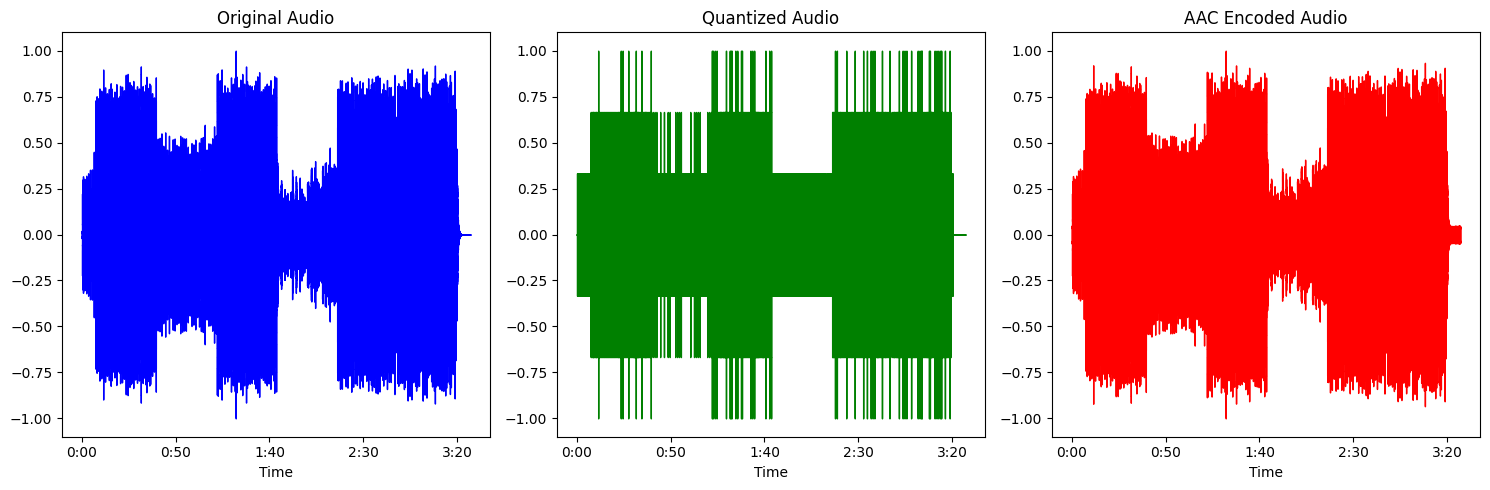

Processing file: speech_office_4.wav, Genre: speech
Perceptual Loss (Quantized): 58.063804626464844, Perceptual Loss (AAC): 28.273242950439453, Ratio: 0.48693403601646423


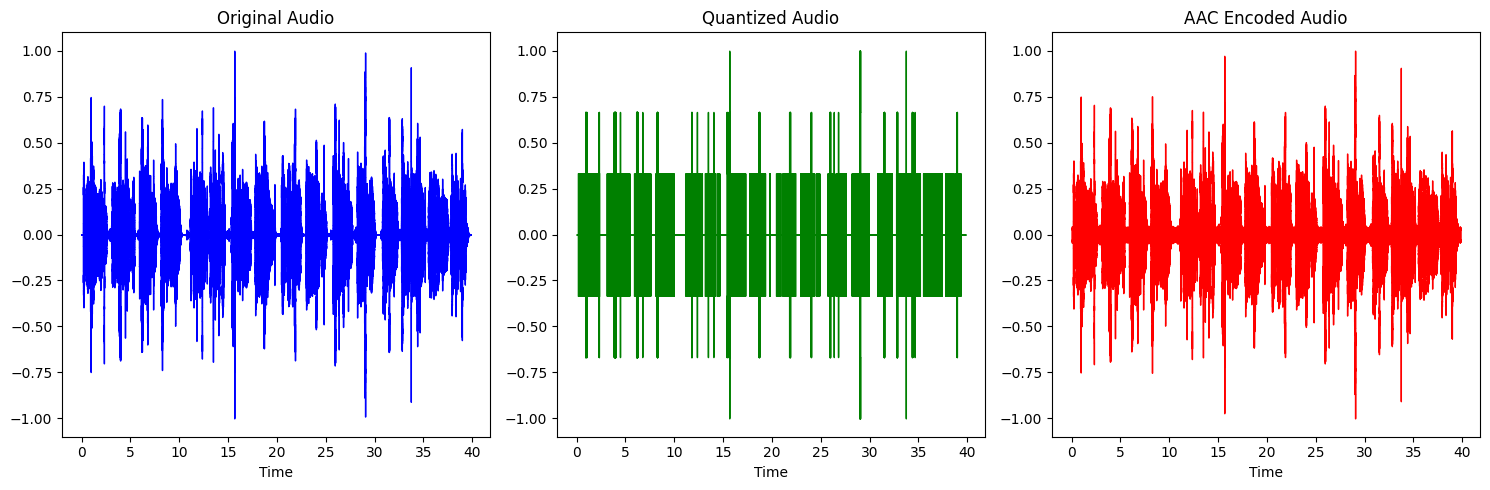

Processing file: speech_reverbance_4.wav, Genre: speech
Perceptual Loss (Quantized): 44.55287551879883, Perceptual Loss (AAC): 20.694320678710938, Ratio: 0.46448901295661926


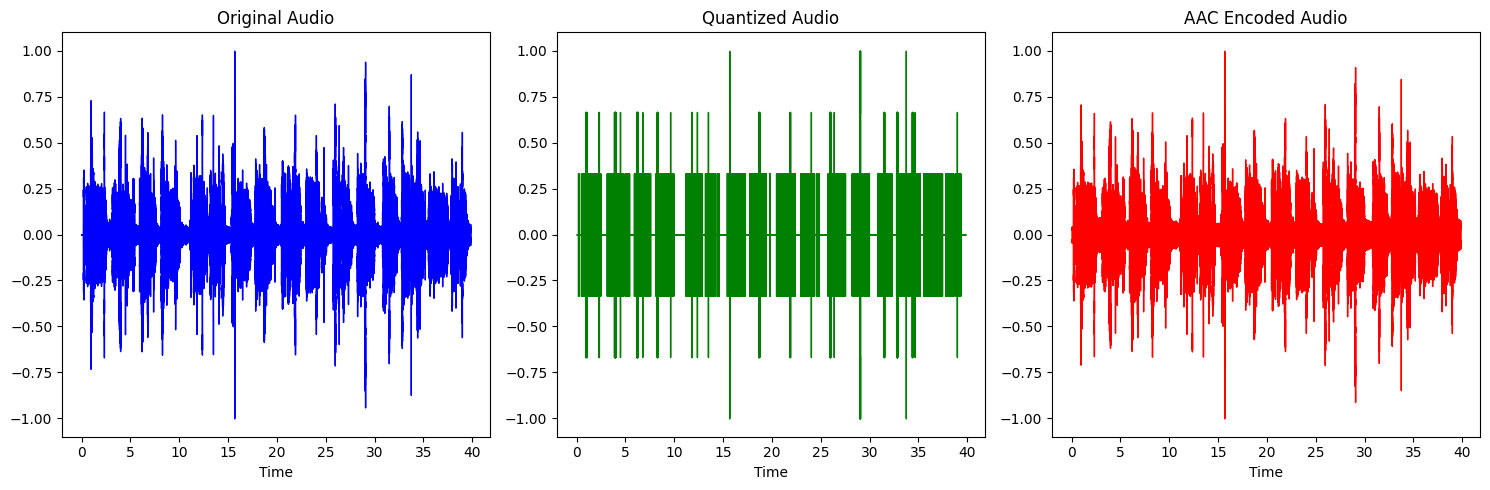

Processing file: speech_reverbhall_4.wav, Genre: speech
Perceptual Loss (Quantized): 39.5851936340332, Perceptual Loss (AAC): 19.55207633972168, Ratio: 0.49392399191856384


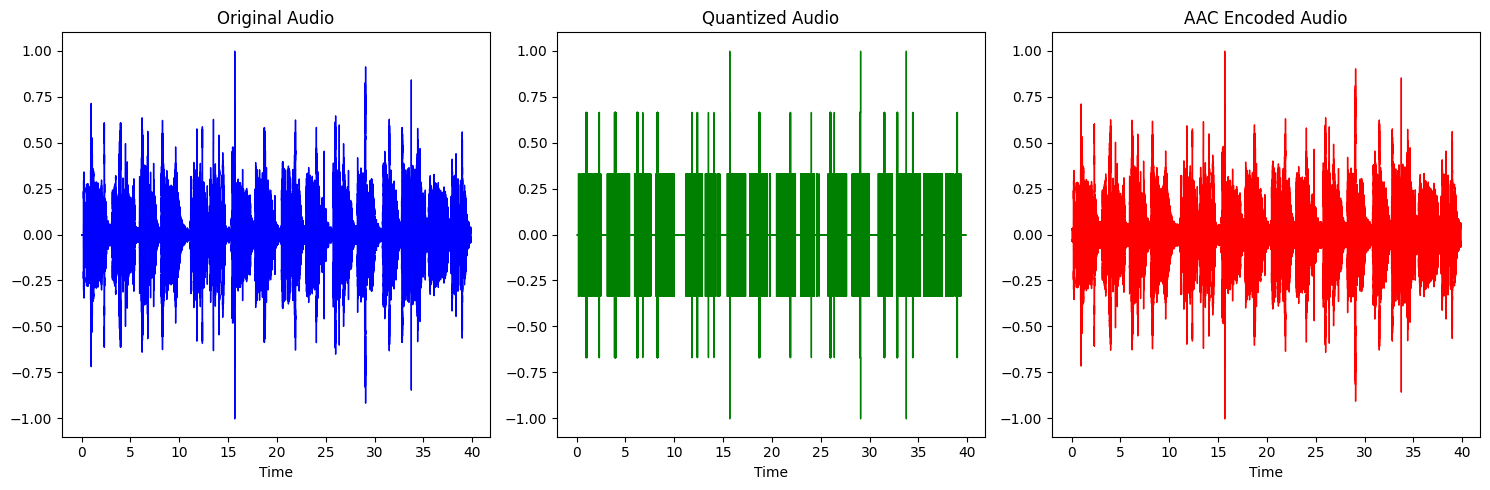

Processing file: speech_sound-4.wav, Genre: speech
Perceptual Loss (Quantized): 65.45404815673828, Perceptual Loss (AAC): 33.45689392089844, Ratio: 0.5111508965492249


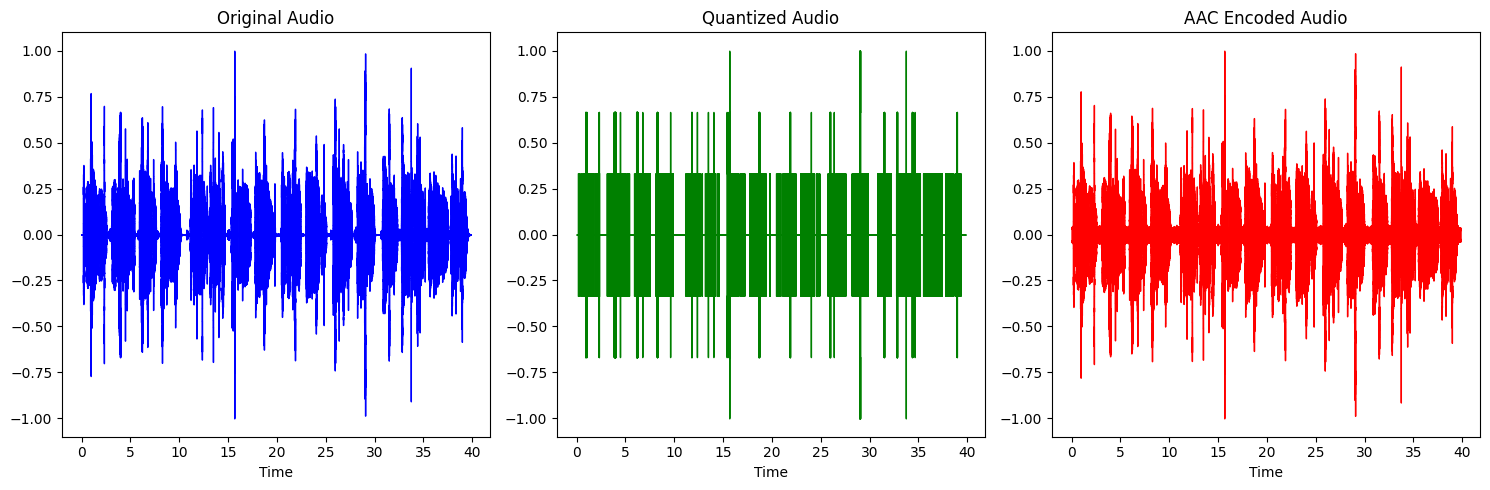

                     file_name     genre  ploss_quant  ploss_aac  \
0            drum_office_3.wav      drum   455.336090  62.954926   
1        drum_reverbance_3.wav      drum   113.767143  33.165112   
2        drum_reverbhall_3.wav      drum   128.371552  43.017136   
3             drum_sound-3.wav      drum   445.511017  64.581520   
4       music_mix_office_1.wav     music     8.846882   0.993606   
5   music_mix_reverbance_1.wav     music    12.714332   0.517456   
6   music_mix_reverbhall_1.wav     music     9.347469   0.986599   
7        music_mix_sound-1.wav     music     4.894348   2.823742   
8           piano_office_5.wav     piano   278.917206  72.067795   
9       piano_reverbance_5.wav     piano   436.637177  68.841454   
10      piano_reverbhall_5.wav     piano   304.328125  71.297203   
11           piano_sound-5.wav     piano   261.961273  70.457779   
12       ringtone_office_2.wav  ringtone    48.303928  19.026060   
13   ringtone_reverbance_2.wav  ringtone   108.4

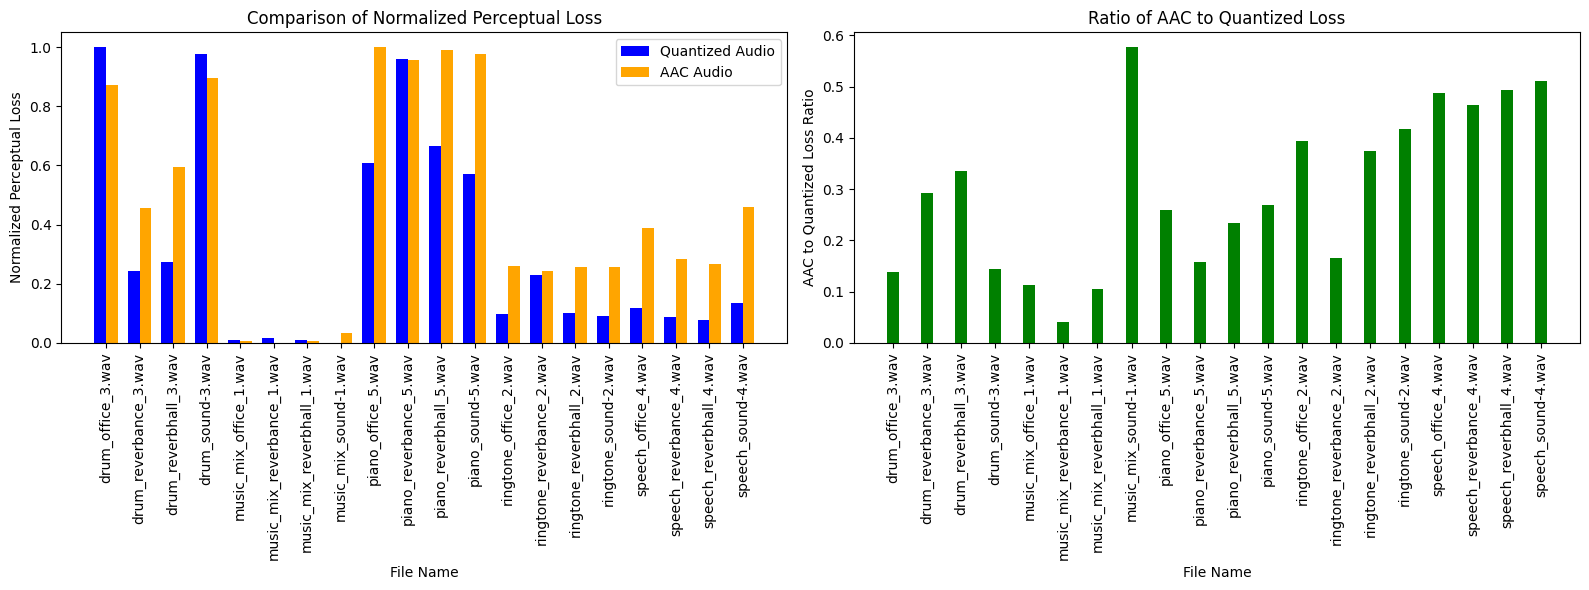

In [6]:
# Process audio files and create DataFrame
audio_files_path = r'/Users/annsb/Desktop/Soundsnew/Sounds'
df = process_audio_files(audio_files_path)

# Save the DataFrame to a CSV file
output_file_path = 'results.csv'
df.to_csv(output_file_path, index=False)

# Display the DataFrame
print(df)

if df.empty:
    print("The DataFrame is empty. No audio files were processed successfully.")
elif 'ploss_quant' not in df.columns or 'ploss_aac' not in df.columns:
    print("The DataFrame is missing expected columns. Check the audio processing step.")
else:
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    bar_width = 0.35
    positions = range(len(df))

    df['norm_ploss_quant'] = (df['ploss_quant'] - df['ploss_quant'].min()) / (df['ploss_quant'].max() - df['ploss_quant'].min())
    df['norm_ploss_aac'] = (df['ploss_aac'] - df['ploss_aac'].min()) / (df['ploss_aac'].max() - df['ploss_aac'].min())

    plt.bar(positions, df['norm_ploss_quant'], bar_width, label='Quantized Audio', color='blue')
    plt.bar([pos + bar_width for pos in positions], df['norm_ploss_aac'], bar_width, label='AAC Audio', color='orange')

    plt.xlabel('File Name')
    plt.ylabel('Normalized Perceptual Loss')
    plt.title('Comparison of Normalized Perceptual Loss')
    plt.xticks([pos + bar_width / 2 for pos in positions], df['file_name'], rotation=90)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(positions, df['aac_to_quant_loss_ratio'], bar_width, color='green')

    plt.xlabel('File Name')
    plt.ylabel('AAC to Quantized Loss Ratio')
    plt.title('Ratio of AAC to Quantized Loss')
    plt.xticks(positions, df['file_name'], rotation=90)

    plt.tight_layout()
    plt.show()
